In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data Prep

## Import, Reading Data dan Basic Stats

In [ ]:
import numpy as np
np.random.seed(10)
import string
import json
import joblib
import pandas as pd
import tensorflow as tf
import string
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import csv

In [ ]:
BASE_DIR = '/content/drive/My Drive/Machine Learning/Quora/'
TRAIN_DATA = 'quora_train.csv'
GLOVE_FILE = 'glove_idwiki_100d.txt'
Q1_TRAIN_FILE = 'q1_train.npy'
Q2_TRAIN_FILE = 'q2_train.npy'
LABEL_FILE = 'target_labels.npy'
GLOVE_EMBEDDING_MATRIX_FILE = 'glove_word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100

In [ ]:
train_data = pd.read_csv(BASE_DIR + TRAIN_DATA)

In [ ]:
train_data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,Bagaimana tren teknologi masa depan setelah er...,Apa teknologi terbaru Bluetooth,0
1,1,3,4,Bagaimana cara agar kemampuan pemrograman maha...,Apa bukti bahwa robot cyborg sudah ada saat ini,0
2,2,5,6,Apa yang harus diperhatikan sebelum membeli ke...,Apa saja yang harus dipertimbangkan sebelum me...,1
3,3,7,8,Apa perangkat lunak software yang bagus diguna...,Apa perangkat lunak yang bagus untuk merekam l...,1
4,4,9,10,Pernahkah Anda berpikir sekarang ini membuat o...,Mengapa masyarakat awam menilai bahwa orang ya...,0
...,...,...,...,...,...,...
9995,9995,19991,19992,Berapa bid yang ideal untuk iklan di aplikasi ...,Berapa tawaran ideal untuk beriklan di aplikas...,1
9996,9996,19993,19994,Seperti apa pengalamanmu menjadi seorang penju...,Apa pengalaman Anda sebagai penjual makanan beku,1
9997,9997,19995,19996,Bagaimana agar video TikTok kita masuk fyp,Bagaimana tips dan trik membuka suatu usaha,0
9998,9998,19997,19998,Apa tips untuk jualan daring agar laris manis,Apa rahasia berjualan online,1


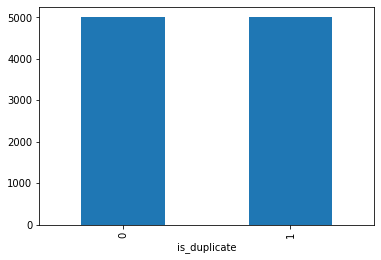

In [ ]:
train_data.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
print('~> Total nomor dari identifikasi pertanyaan untuk training:\n   {}'.format(len(train_data)))

~> Total nomor dari identifikasi pertanyaan untuk training:
   10000


In [ ]:
print('~> Pertanyaan yang beda (is_duplicate = 0):\n   {}%'.format(100 - round(train_data['is_duplicate'].mean()*100, 2)))
print('\n~> Pertanyaan yang sama (is_duplicate = 1):\n   {}%'.format(round(train_data['is_duplicate'].mean()*100, 2)))

~> Pertanyaan yang beda (is_duplicate = 0):
   50.0%

~> Pertanyaan yang sama (is_duplicate = 1):
   50.0%


In [ ]:
train_data.describe()

,id,qid1,qid2,is_duplicate
count,10000.00000,10000.00000,10000.00000,10000.000000
mean,4999.50000,10000.00000,10001.00000,0.500000
std,2886.89568,5773.79136,5773.79136,0.500025
min,0.00000,1.00000,2.00000,0.000000
25%,2499.75000,5000.50000,5001.50000,0.000000
50%,4999.50000,10000.00000,10001.00000,0.500000
75%,7499.25000,14999.50000,15000.50000,1.000000
max,9999.00000,19999.00000,20000.00000,1.000000


In [ ]:
train_data[train_data['is_duplicate'] > 0].describe()

,id,qid1,qid2,is_duplicate
count,5000.000000,5000.000000,5000.000000,5000.0
mean,4684.335800,9369.671600,9370.671600,1.0
std,3017.672382,6035.344764,6035.344764,0.0
min,2.000000,5.000000,6.000000,1.0
25%,2034.750000,4070.500000,4071.500000,1.0
50%,4312.000000,8625.000000,8626.000000,1.0
75%,7540.250000,15081.500000,15082.500000,1.0
max,9999.000000,19999.000000,20000.000000,1.0


In [ ]:
len(train_data[train_data['is_duplicate'] > 0]['qid1'].unique())

5000

In [ ]:
len(train_data['qid1'].unique())

10000

## Preprocessing

### Clean pertanyaan

In [ ]:
# Sudah dilakukan di Microsoft Office Excel
# train_data['question1'] = train_data['question1'].str.replace('[^\w\s]','')
# train_data['question2'] = train_data['question2'].str.replace('[^\w\s]','')

### Case Folding

In [ ]:
train_data['question1'] = train_data['question1'].str.lower()
train_data['question2'] = train_data['question2'].str.lower()

train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,bagaimana tren teknologi masa depan setelah er...,apa teknologi terbaru bluetooth,0
1,1,3,4,bagaimana cara agar kemampuan pemrograman maha...,apa bukti bahwa robot cyborg sudah ada saat ini,0
2,2,5,6,apa yang harus diperhatikan sebelum membeli ke...,apa saja yang harus dipertimbangkan sebelum me...,1
3,3,7,8,apa perangkat lunak software yang bagus diguna...,apa perangkat lunak yang bagus untuk merekam l...,1
4,4,9,10,pernahkah anda berpikir sekarang ini membuat o...,mengapa masyarakat awam menilai bahwa orang ya...,0


In [ ]:
#simpan hasil
train_data.to_csv(BASE_DIR + 'fix_cleaned.csv', sep=',')

In [ ]:
clean_data = pd.read_csv(BASE_DIR + 'fix_cleaned.csv', index_col=0)
clean_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,bagaimana tren teknologi masa depan setelah er...,apa teknologi terbaru bluetooth,0
1,1,3,4,bagaimana cara agar kemampuan pemrograman maha...,apa bukti bahwa robot cyborg sudah ada saat ini,0
2,2,5,6,apa yang harus diperhatikan sebelum membeli ke...,apa saja yang harus dipertimbangkan sebelum me...,1
3,3,7,8,apa perangkat lunak software yang bagus diguna...,apa perangkat lunak yang bagus untuk merekam l...,1
4,4,9,10,pernahkah anda berpikir sekarang ini membuat o...,mengapa masyarakat awam menilai bahwa orang ya...,0


### Stopwords

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
question_1 = []
question_2 = []
is_duplicate = []

with open(BASE_DIR + 'fix_cleaned.csv', encoding = 'utf-8') as csvfile:
  reader = csv.DictReader(csvfile)
  for row in reader:
    question_1.append(row['question1'])
    question_2.append(row['question2'])
    is_duplicate.append(row['is_duplicate'])

print(f"# of questions: {len(question_1)}")

# of questions: 10000


In [ ]:
clean_data['question1'][2]

'apa yang harus diperhatikan sebelum membeli keyboard komputer'

In [ ]:
# functions for cleaning questions
def load_doc(filepath):
  file = open(filepath, 'r')
  text = file.read()
  file.close()
  return text

def clean_question(question):
  tokens = word_tokenize(question)
  stop_words = set(stopwords.words('indonesian'))
  tokens = [w for w in tokens if not w in stop_words]
# tokens = [w for w in tokens if w.isalpha()] keep only alphabet
  tokens = ' '.join(tokens)
  return tokens

def process_question(question):
  clean_q = []
  for q in question:
    q  = str(q)
    qs = clean_question(q)
    clean_q.append(qs)
  return clean_q

question1_clean = process_question(question_1)
question2_clean = process_question(question_2)

Contoh dataset *question1* **Sebelum** dilakukan **Stopwords Removal**

In [ ]:
clean_data['question1'][2]

'apa yang harus diperhatikan sebelum membeli keyboard komputer'

Contoh dataset *question1* **Setelah** dilakukan **Stopwords Removal**

In [ ]:
question1_clean[2]

'diperhatikan membeli keyboard komputer'

### Tokenize Word

In [ ]:
questions = question1_clean + question2_clean
tokenizer = Tokenizer() #Tokenize the sentences
tokenizer.fit_on_texts(questions) #preparing vocabulary

#converting text into integer sequences
question1_word_sequences = tokenizer.texts_to_sequences(question1_clean)
question2_word_sequences = tokenizer.texts_to_sequences(question2_clean)

word_index = tokenizer.word_index
print(f"Words in index: {len(word_index)}")

Words in index: 12484


In [ ]:
# size_of_vocabulary = len(tokenizer.word_index) + 1 #+1 for padding
# print(size_of_vocabulary)

In [ ]:
print(word_index)

{'game': 1, 'aplikasi': 2, 'ponsel': 3, 'teknologi': 4, 'perusahaan': 5, 'indonesia': 6, 'laptop': 7, 'komputer': 8, 'bahasa': 9, 'belajar': 10, 'orang': 11, 'internet': 12, 'memiliki': 13, 'android': 14, 'video': 15, 'terbaik': 16, 'startup': 17, 'jaringan': 18, 'bisnis': 19, 'pemrograman': 20, 'bermain': 21, '4': 22, '5g': 23, 'industri': 24, 'dunia': 25, 'google': 26, 'adakah': 27, 'data': 28, 'smartphone': 29, 'produk': 30, 'uang': 31, 'hp': 32, 'perangkat': 33, 'perbedaan': 34, 'bagus': 35, 'membeli': 36, 'ram': 37, '1': 38, 'kerja': 39, 'pc': 40, '0': 41, 'harga': 42, 'cepat': 43, 'menurutmu': 44, 'daring': 45, 'playstation': 46, 'web': 47, 'telepon': 48, '2': 49, 'windows': 50, 'sistem': 51, '5': 52, 'konsol': 53, 'intel': 54, 'mempelajari': 55, 'merek': 56, 'iphone': 57, 'amd': 58, 'era': 59, 'dibandingkan': 60, 'prosesor': 61, 'lunak': 62, '10': 63, 'mudah': 64, 'pengalaman': 65, 'digital': 66, 'usaha': 67, 'server': 68, 'bidang': 69, 'fi': 70, 'kelebihan': 71, 'microsoft': 72

In [ ]:
print(question1_clean[2])
print(question1_word_sequences[2])

diperhatikan membeli keyboard komputer
[533, 36, 188, 8]


## Proses Embedding

In [ ]:
# define some functions to process pre-trained embedding
nb_words = min(MAX_NB_WORDS, len(word_index))

def load_embedding(filepath):
  file = open(filepath, 'r', encoding = 'utf-8')
  embeddings = {}
  for line in file:
    values = line.split(' ')
    word = values[0]
    vec = np.asarray(values[1:], dtype = 'float32')
    embeddings[word] = vec
  return embeddings

def get_weight_matrix(embedding):
  weight_matrix = np.zeros((nb_words+1, EMBEDDING_DIM)) #+1 for padding
  for word, i in word_index.items():
    if i > MAX_NB_WORDS:
      continue
    embedding_vector = embedding.get(word)
    if embedding_vector is not None:
      weight_matrix[i] = embedding_vector
  return weight_matrix

raw_embedding = load_embedding(BASE_DIR + GLOVE_FILE)
word_embedding_matrix = get_weight_matrix(raw_embedding)
print(f"embedding shape: {word_embedding_matrix.shape}")
print(f"Word embeddings: {len(raw_embedding)}")

embedding shape: (12485, 100)
Word embeddings: 377829


In [ ]:
raw_embedding['komputer']

array([ 1.111384e+00, -1.563000e-03, -7.270840e-01, -9.626970e-01,
        2.860490e-01,  3.357970e-01,  3.992800e-01,  2.633830e-01,
        7.382550e-01,  7.413360e-01,  6.822090e-01,  7.918120e-01,
       -3.615330e-01,  3.165320e-01, -2.041330e-01,  9.013810e-01,
        7.123830e-01,  3.420170e-01, -1.305085e+00,  1.030437e+00,
        3.122610e-01,  2.901620e-01,  5.651790e-01,  3.521330e-01,
        6.772180e-01, -6.491970e-01,  2.031330e-01,  6.186200e-02,
       -4.454770e-01,  6.809730e-01,  4.679450e-01, -2.544180e-01,
        6.591870e-01,  1.729770e-01,  4.376200e-02, -5.672100e-02,
        1.585930e-01, -1.527210e-01,  3.689520e-01,  7.532700e-02,
        6.439750e-01,  1.723768e+00,  1.588900e-02, -6.292950e-01,
        3.177740e-01,  6.078270e-01, -8.527210e-01, -1.202620e+00,
       -1.543450e-01, -1.913239e+00, -3.295900e-02,  2.525630e-01,
        6.407470e-01,  8.962570e-01, -7.979300e-01, -3.270970e-01,
       -4.991760e-01, -1.001657e+00, -1.843060e-01,  2.508500e

## Prepare Training Data

In [ ]:
q1_data = pad_sequences(question1_word_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
q2_data = pad_sequences(question2_word_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
labels = np.array(is_duplicate, dtype = 'int')

print(f"Shape of q1_data: {q1_data.shape}")
print(f"shape of q2_data: {q2_data.shape}")
print(f"Shape of target class: {labels.shape}")

Shape of q1_data: (10000, 50)
shape of q2_data: (10000, 50)
Shape of target class: (10000,)


In [ ]:
q1_data[2]

array([533,  36, 188,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
q1_data

array([[371,   4,  59, ...,   0,   0,   0],
       [246,  20, 289, ...,   0,   0,   0],
       [533,  36, 188, ...,   0,   0,   0],
       ...,
       [ 15, 171, 195, ...,   0,   0,   0],
       [114, 940,  45, ...,   0,   0,   0],
       [ 27, 102,  92, ...,   0,   0,   0]], dtype=int32)

In [ ]:
labels

array([0, 0, 1, ..., 0, 1, 1])

## Save Process Data

In [ ]:
np.save(open(BASE_DIR + Q1_TRAIN_FILE, 'wb'), q1_data) #Simpan q1_data
np.save(open(BASE_DIR + Q2_TRAIN_FILE, 'wb'), q2_data) #Simpan q2_data
np.save(open(BASE_DIR + LABEL_FILE, 'wb'), labels) #Simpan label
np.save(open(BASE_DIR + GLOVE_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix) #Simpan word_embedding_matrix
with open(BASE_DIR + NB_WORDS_DATA_FILE,'w') as f: #Simpan nb_words dalam format json
  json.dump({'nb_words': nb_words}, f)

import pickle
with open(BASE_DIR + 'tokenizer.pkl', 'wb') as handle: # Simpan Tokenizer.pkl
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Build Train Model

## Import Packages

In [ ]:
import time, json
from keras.models import Model, load_model
from keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## initialize variables

In [ ]:
BI_MODEL_PATH = 'bi_quora_question_pairs.h5'
PLOT_MODEL = 'bi_model.png'
MAX_SEQUENCE_LENGTH = 50
GLOVE_EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
EPOCHS = 6
DROPOUT = 0.2
BATCH_SIZE = 32

## Load and split data

In [ ]:
# load data
q1_data = np.load(open(BASE_DIR + Q1_TRAIN_FILE, 'rb'))
q2_data = np.load(open(BASE_DIR + Q2_TRAIN_FILE, 'rb'))
glove_embedding_matrix = np.load(open(BASE_DIR + GLOVE_EMBEDDING_MATRIX_FILE, 'rb'))
labels = np.load(open(BASE_DIR + LABEL_FILE, 'rb'))
with open(BASE_DIR + NB_WORDS_DATA_FILE, 'r') as f:
  nb_words = json.load(f)['nb_words']
      

# split data
X = np.stack((q1_data, q2_data), axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = VALIDATION_SPLIT, random_state = 42)

Q1_train = X_train[:, 0]
Q2_train = X_train[:, 1]
Q1_test = X_test[:, 0]
Q2_test = X_test[:, 1]

In [ ]:
print(len(labels))

10000


## Build Model

In [ ]:
# using GloVe embedding

q1_input = Input(shape = (MAX_SEQUENCE_LENGTH,))
q2_input = Input(shape = (MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words+1, 
               GLOVE_EMBEDDING_DIM, 
               input_length = MAX_SEQUENCE_LENGTH,
               weights = [glove_embedding_matrix], 
               trainable = False)(q1_input)
q1 = Bidirectional(LSTM(128))(q1)

q2 = Embedding(nb_words+1,
               GLOVE_EMBEDDING_DIM,
               input_length = MAX_SEQUENCE_LENGTH,
               weights = [glove_embedding_matrix],
               trainable = False)(q2_input)
q2 = Bidirectional(LSTM(128))(q2)

merged = Concatenate()([q1,q2])
merged = Dense(128, activation = 'relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(DROPOUT)(merged)
merged = Dense(64, activation = 'relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(DROPOUT)(merged)
merged = Dense(32, activation = 'relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(DROPOUT)(merged)

merged = Dense(1, activation = 'sigmoid')(merged)

model = Model(inputs = [q1_input, q2_input], outputs = merged)
opt = Adam(lr = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      1248500     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      1248500     input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
t0 = time.time()
callbacks = ModelCheckpoint(BASE_DIR + BI_MODEL_PATH, monitor = 'val_loss',
                            mode='min', verbose = 1, save_best_only = True)
history = model.fit([Q1_train, Q2_train], 
                    y_train,
                    verbose = 1,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = [callbacks], 
                    validation_split = VALIDATION_SPLIT)
t1 = time.time()
print(f"total training time: {round((t1-t0)/60,2)} minutes")

Epoch 1/6
198/200 [============================>.] - ETA: 0s - loss: 0.3506 - accuracy: 0.8493
Epoch 00001: val_loss improved from inf to 0.27328, saving model to /content/drive/My Drive/Machine Learning/Quora/bi_quora_question_pairs.h5
200/200 [==============================] - 5s 25ms/step - loss: 0.3491 - accuracy: 0.8505 - val_loss: 0.2733 - val_accuracy: 0.9056
Epoch 2/6
197/200 [============================>.] - ETA: 0s - loss: 0.2165 - accuracy: 0.9205
Epoch 00002: val_loss improved from 0.27328 to 0.22904, saving model to /content/drive/My Drive/Machine Learning/Quora/bi_quora_question_pairs.h5
200/200 [==============================] - 3s 17ms/step - loss: 0.2183 - accuracy: 0.9202 - val_loss: 0.2290 - val_accuracy: 0.9244
Epoch 3/6
197/200 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9438
Epoch 00003: val_loss improved from 0.22904 to 0.14178, saving model to /content/drive/My Drive/Machine Learning/Quora/bi_quora_question_pairs.h5
200/200 [========

## Evaluate the model with best validation accuracy

In [ ]:
model = load_model(BASE_DIR + BI_MODEL_PATH)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose = 0)
print(f"loss = {loss}, accuracy = {accuracy}")

loss = 0.14678974449634552, accuracy = 0.9495000243186951


In [ ]:
y_pred = model.predict([Q1_test, Q2_test])
y_pred_class = np.round(y_pred) # argmax for categorical crossentropy

In [ ]:
class_rep = classification_report(y_pred_class, y_test)
print(class_rep)

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       961
         1.0       0.97      0.94      0.95      1039

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [ ]:
y_pred

array([[9.8465360e-04],
       [3.6493766e-03],
       [9.9386168e-01],
       ...,
       [2.4101427e-03],
       [9.8423344e-01],
       [1.5263919e-04]], dtype=float32)

In [ ]:
y_pred_class

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

Support: Hasil dari split 0.2 (20%)

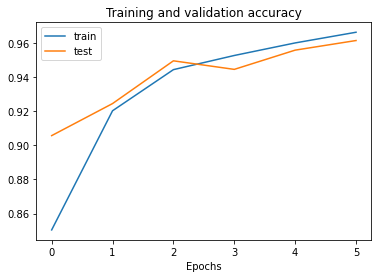

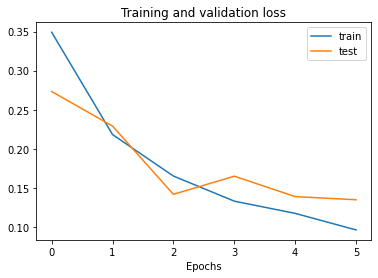

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

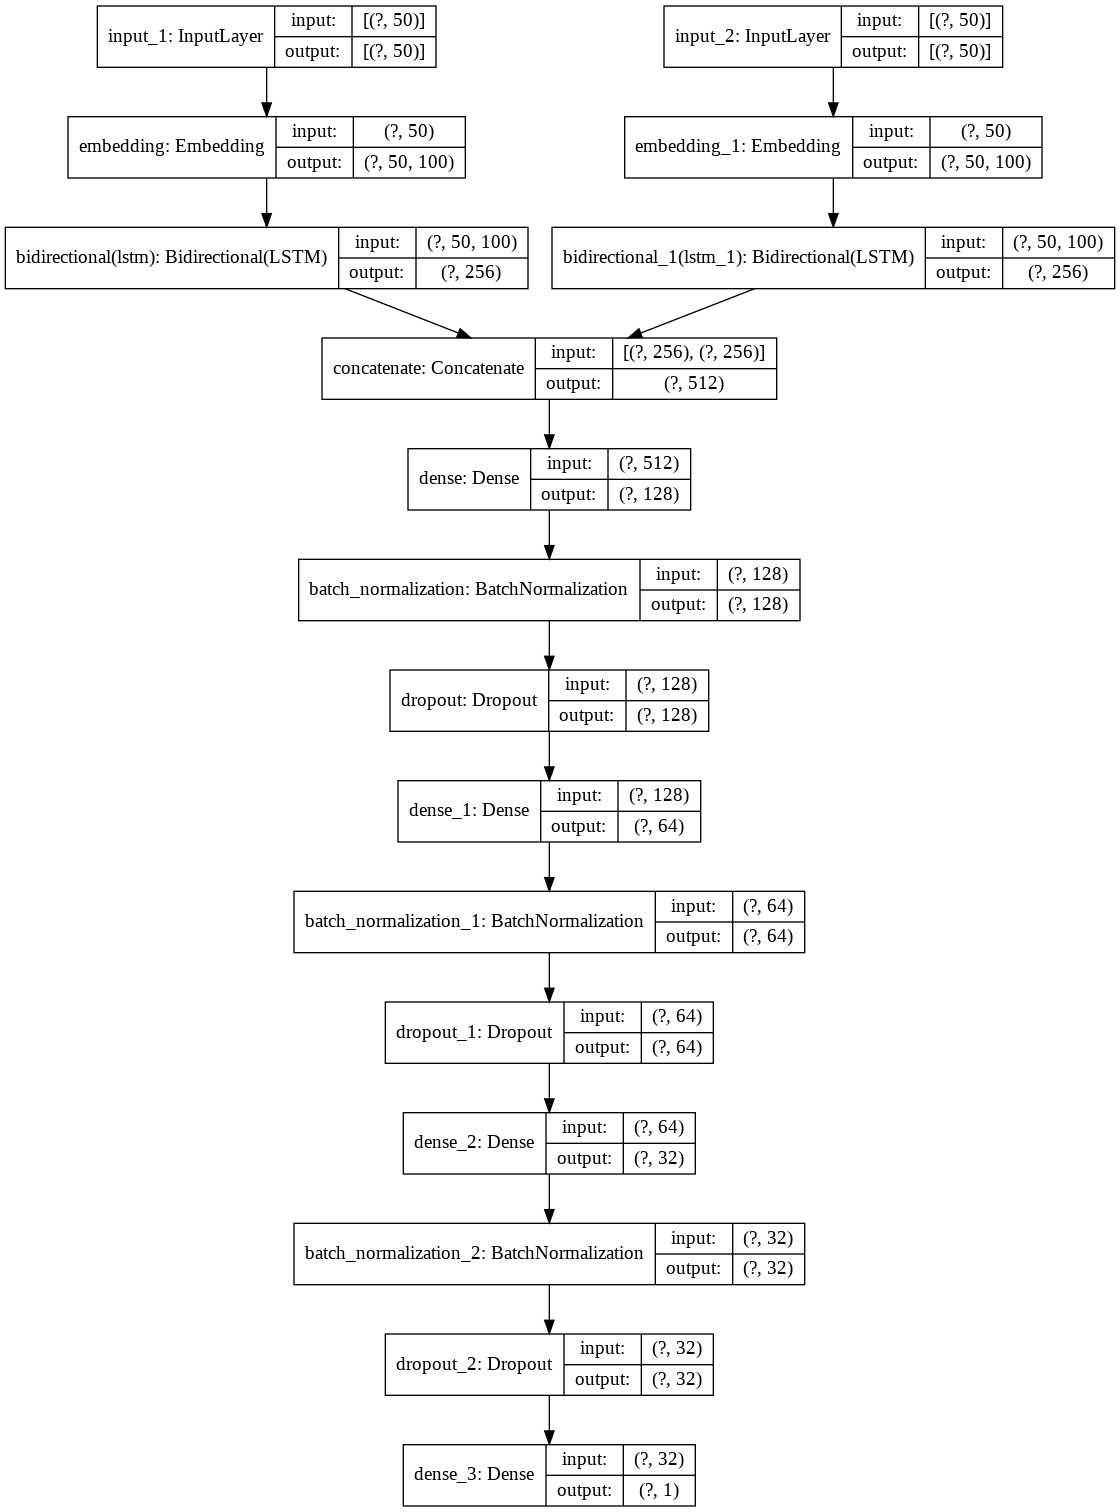

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file = BASE_DIR + PLOT_MODEL, show_shapes = True, show_layer_names = True)

# Confusion Matrix (Perhitungan Akurasi)

## Ploting

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_pred_class, y_test) * 100
print("Accuracy score is {}%.".format(round(accuracy),1))
print()
print("Confusion Matrix:")
print(confusion_matrix(y_pred_class, y_test))
print()

Accuracy score is 95.0%.

Confusion Matrix:
[[926  35]
 [ 66 973]]



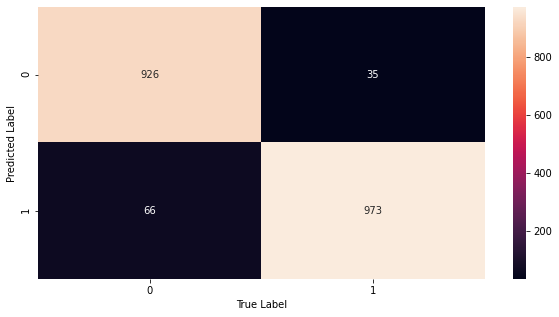

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix(y_pred_class, y_test.round()), annot=True, fmt=".0f", ax=ax)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

## Ploting chart pie

In [ ]:
jumlah_0_pred = 0
jumlah_1_pred = 0

for i in y_pred_class :
  if i == 0 :
    jumlah_0_pred += 1
  
  else :
    jumlah_1_pred += 1

print(jumlah_0_pred)
print(jumlah_1_pred)

961
1039


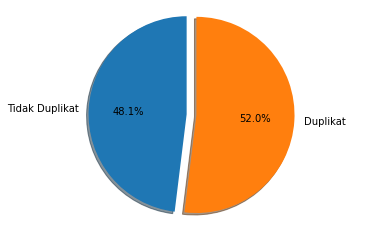

In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Tidak Duplikat', 'Duplikat'
sizes = [jumlah_0_pred, jumlah_1_pred]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()